# Mask R-CNN for Human Pose Estimation Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [4]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "mylogs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco_humanpose.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
COCO_DIR = "D:/Eigene Dateien/Dokumente/coco"  # TODO: enter value here

## Configurations

Run one of the code blocks below to import and load the configurations to use.

In [2]:
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    KEYPOINT_MASK_POOL_SIZE = 7

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()[1]
model_path = os.path.join(ROOT_DIR, "mask_rcnn_coco_humanpose.h5")
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Loading weights from  C:\Users\LStue\Mask_RCNN_Humanpose\mask_rcnn_coco_humanpose.h5


## Dataset

In [5]:
# Load dataset
assert inference_config.NAME == "coco"
# Training dataset
#load person keypoints dataset
train_dataset_keypoints = coco.CocoDataset(task_type="person_keypoints")
train_dataset_keypoints.load_coco(COCO_DIR, "train")
train_dataset_keypoints.prepare() 

val_dataset_keypoints = coco.CocoDataset(task_type="person_keypoints")
val_dataset_keypoints.load_coco(COCO_DIR, "val")
val_dataset_keypoints.prepare() 

print("Train Keypoints Image Count: {}".format(len(train_dataset_keypoints.image_ids)))
print("Train Keypoints Class Count: {}".format(train_dataset_keypoints.num_classes))
for i, info in enumerate(train_dataset_keypoints.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    
print("Val Keypoints Image Count: {}".format(len(val_dataset_keypoints.image_ids)))
print("Val Keypoints Class Count: {}".format(val_dataset_keypoints.num_classes))
for i, info in enumerate(val_dataset_keypoints.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=9.70s)
creating index...
index created!
Skeleton: (19, 2)
Keypoint names: (17,)
loading annotations into memory...
Done (t=1.51s)
creating index...
index created!
Skeleton: (19, 2)
Keypoint names: (17,)
Train Keypoints Image Count: 64115
Train Keypoints Class Count: 2
  0. BG                                                
  1. person                                            
Val Keypoints Image Count: 2693
Val Keypoints Class Count: 2
  0. BG                                                
  1. person                                            


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (10,)                 min:    0.00000  max: 2467.00000  int32
gt_class_id              shape: (4,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (4, 4)                min:  129.00000  max:  946.00000  int32
gt_mask                  shape: (56, 56, 4)           min:    0.00000  max:    1.00000  bool
gt_keypoint              shape: (4, 17, 3)            min:    0.00000  max:  234.00000  int32
keypoint_shape: (4, 17, 3)


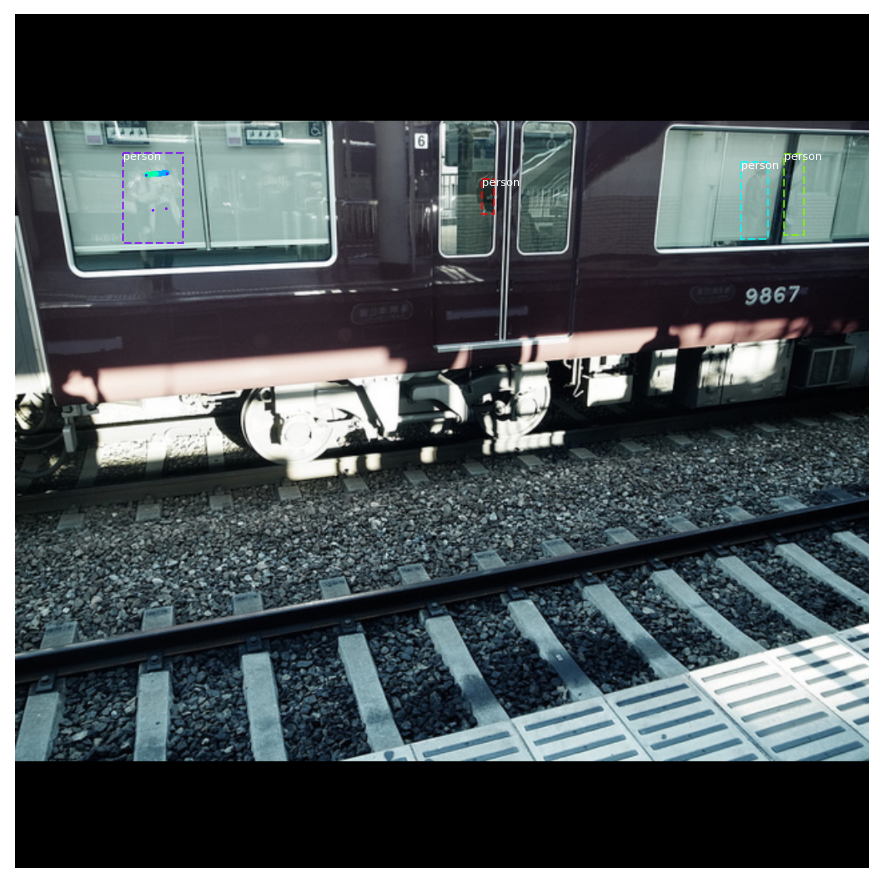

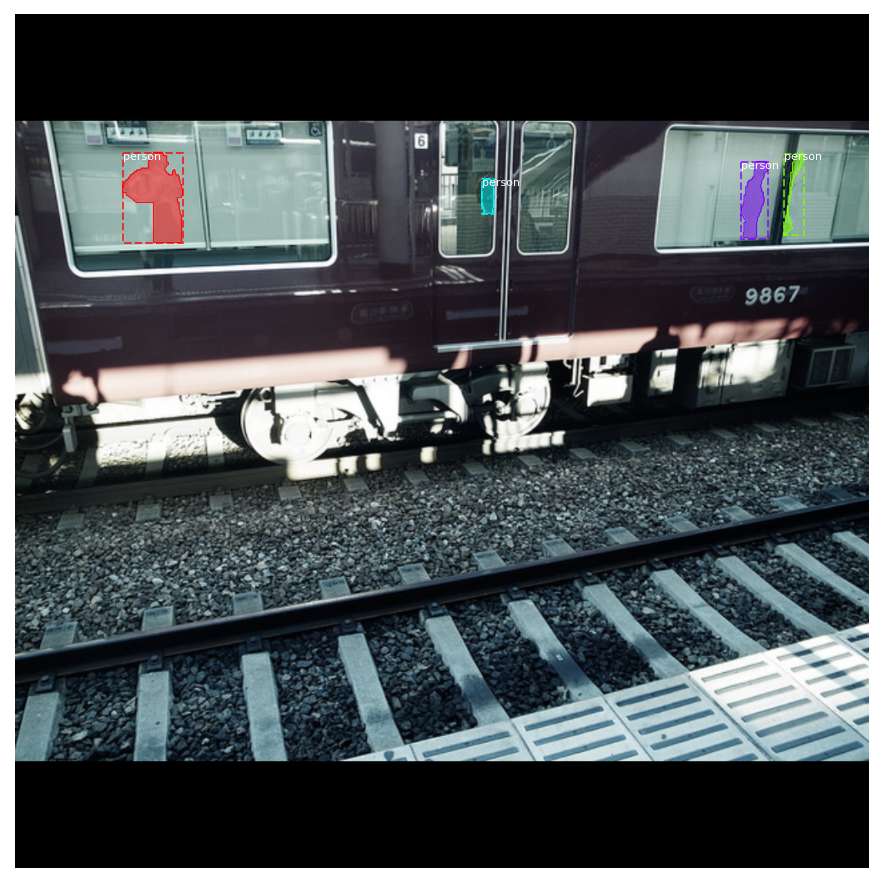

In [7]:
# Test on a random image
image_id = random.choice(val_dataset_keypoints.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_keypoint =\
    modellib.load_image_gt_keypoints(val_dataset_keypoints, inference_config, 
                           image_id, augment=False,use_mini_mask=inference_config.USE_MINI_MASK)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
log("gt_keypoint", gt_keypoint)
visualize.display_keypoints(original_image,gt_bbox,gt_keypoint,gt_class_id,val_dataset_keypoints.class_names, skeleton = inference_config.LIMBS)
if(inference_config.USE_MINI_MASK):
    gt_mask = utils.expand_mask(gt_bbox,gt_mask,original_image.shape)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            val_dataset_keypoints.class_names,)

# original_image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_keypoint =\
#     modellib.load_image_gt_keypoints(val_dataset_keypoints, inference_config, 
#                            image_id, augment=True,use_mini_mask=inference_config.USE_MINI_MASK)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)
# log("gt_keypoint", gt_keypoint)
# visualize.display_keypoints(original_image,gt_bbox,gt_keypoint,gt_class_id,val_dataset_keypoints.class_names)
# if(inference_config.USE_MINI_MASK):
#     gt_mask = utils.expand_mask(gt_bbox,gt_mask,original_image.shape)
# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             val_dataset_keypoints.class_names,)


## Dataset

rois                     shape: (0, 4)                min:             max:             int32
keypoints                shape: (0, 17, 3)            min:             max:             float64
class_ids                shape: (0,)                  min:             max:             int32
keypoints                shape: (0, 17, 3)            min:             max:             float64
masks                    shape: (0, 28, 28)           min:             max:             float64
keypoint_shape: (0, 17, 3)

*** No persons to display *** 



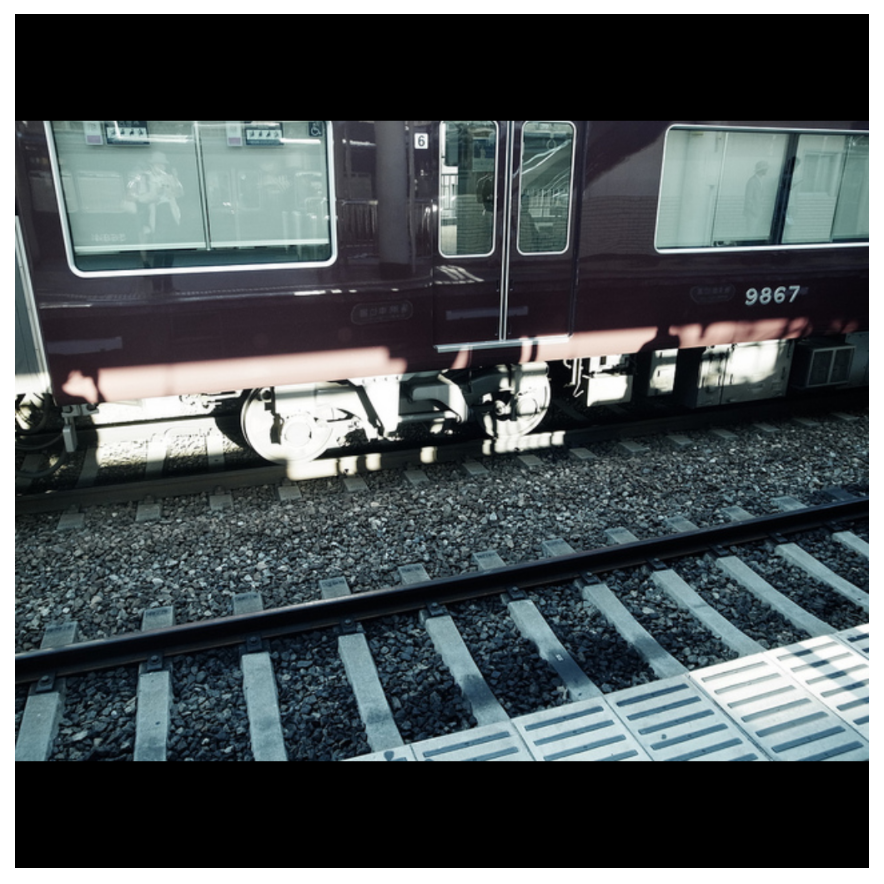


*** No instances to display *** 



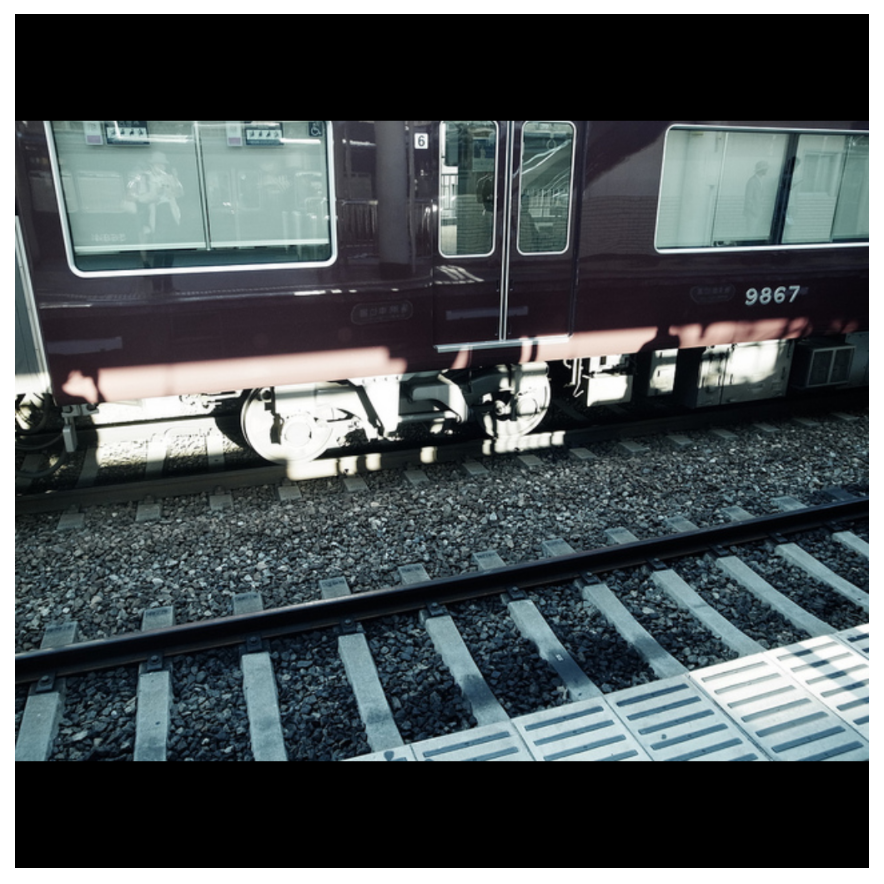

In [8]:
results = model.detect_keypoint([original_image], verbose=0)

r = results[0] # for one image

log("rois",r['rois'])
log("keypoints",r['keypoints'])
log("class_ids",r['class_ids'])
log("keypoints",r['keypoints'])
log("masks",r['masks'])

visualize.display_keypoints(original_image,r['rois'],r['keypoints'],r['class_ids'],val_dataset_keypoints.class_names)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            val_dataset_keypoints.class_names, r['scores'])